<a href="https://colab.research.google.com/github/macorony/NeuralNetwork/blob/main/train_model_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [34]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime

In [3]:
device = ('cuda' if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [4]:
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
[classes[i] for i in [1,2,3]]

['automobile', 'bird', 'cat']

In [5]:
transform = transforms.Compose([transforms.ToTensor()])

In [6]:
train_data = torchvision.datasets.CIFAR10('./data', train=True, download=True, transform=transform)
test_data = torchvision.datasets.CIFAR10('./data', train=False, download=True, transform=transform)

100%|██████████| 170498071/170498071 [00:03<00:00, 49132601.56it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [7]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=4, shuffle=True, num_workers=2)
test_loader =  torch.utils.data.DataLoader(test_data, batch_size=4, shuffle=True, num_workers=2)

In [8]:
for i, data in enumerate(train_loader):
  print(train_loader)
  dummy_data = data
  break

In [9]:
dummy_data[0].shape

torch.Size([4, 3, 32, 32])

In [10]:
def loader_show(dataloader):
  images, labels = next(iter(train_loader))
  grid = torchvision.utils.make_grid(images)
  plt.imshow(grid.permute(1,2,0))
  print([classes[i] for i in labels])
  plt.show()

['airplane', 'horse', 'horse', 'bird']


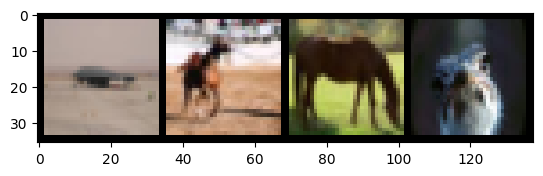

['bird', 'horse', 'horse', 'dog']


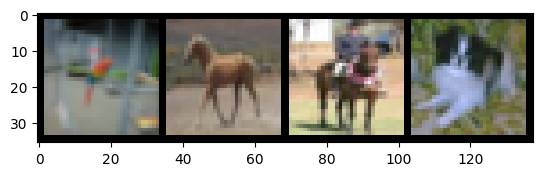

['automobile', 'automobile', 'horse', 'automobile']


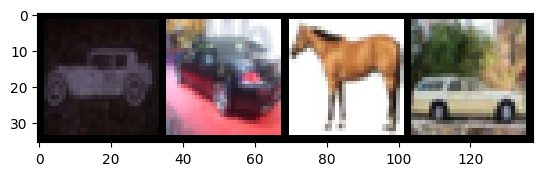

['cat', 'ship', 'cat', 'bird']


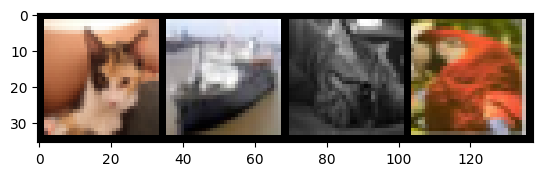

In [11]:
for _ in range(4):
  loader_show(train_loader)

## Model

In [12]:
class NNmodel(nn.Module):
  def __init__(self):
    super(NNmodel, self).__init__()
    self.conv1 = nn.Conv2d(3, 6, 5)
    self.pool = nn.MaxPool2d(2, 2)
    self.conv2 = nn.Conv2d(6, 16, 5)
    self.fc1 = nn.Linear(400, 120)
    self.fc2 = nn.Linear(120, 80)
    self.fc3 = nn.Linear(80, 10)

  def forward(self, input):
    x = self.pool(F.relu(self.conv1(input)))
    x = self.pool(F.relu(self.conv2(x)))
    x = torch.flatten(x,1)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    output = self.fc3(x)
    return output

model = NNmodel()
print(model)

NNmodel(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=80, bias=True)
  (fc3): Linear(in_features=80, out_features=10, bias=True)
)


## Loss function

In [13]:
loss_fun = nn.CrossEntropyLoss()

In [14]:
# a dummy test for loss function
images, labels = next(iter(train_loader))
dummy_label = torch.arange(0, 4)
dummy_output = model(images)
print(dummy_label.shape)
print(dummy_output.shape)
loss = loss_fun(dummy_output, dummy_label)
print(loss.item())

torch.Size([4])
torch.Size([4, 10])
2.2757787704467773


## Optimizer

In [15]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [16]:
model

NNmodel(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=80, bias=True)
  (fc3): Linear(in_features=80, out_features=10, bias=True)
)

## Training

In [17]:
for epoch in range(1):
  running_loss = 0.0
  for i, data in enumerate(train_loader):
    inputs, labels = data
    # zero gradient for every batch
    optimizer.zero_grad()

    outputs = model(inputs)

    loss = loss_fun(outputs, labels)

    loss.backward()

    optimizer.step()

    running_loss += loss.item()
    if i % 2000 == 1999:
      print(f"[{epoch + 1}, {i + 1: 5d}] loss: {running_loss / 2000:.3f}")
      running_loss = 0.0

[1,  2000] loss: 2.242
[1,  4000] loss: 2.027
[1,  6000] loss: 1.858
[1,  8000] loss: 1.720
[1,  10000] loss: 1.623
[1,  12000] loss: 1.581


In [18]:
Path = '/content/drive/MyDrive/file_transmission/cifar10_net.pth'
torch.save(model.state_dict(), Path)

['truck', 'automobile', 'bird', 'horse']


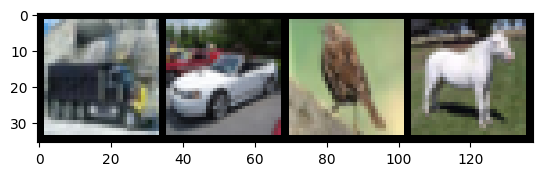

In [19]:
# a simple test
loader_show(test_loader)

In [20]:
correct = 0
total = 0

with torch.no_grad():
  for data in test_loader:
    images, labels = data
    outputs = model(images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

In [21]:
print(f'The accuracy of the model is {100 * correct/total}%')

The accuracy of the model is 45.81%


In [22]:
correct_pred = {classname:0 for classname in classes}
total_pred = {classname:0 for classname in classes}
with torch.no_grad():
  for data in test_loader:
    images, labels = data
    outputs = model(images)
    _, predicted = torch.max(outputs, 1)
    for i, item in enumerate(predicted==labels):
      label = classes[labels[i].item()]
      total_pred[label] = total_pred.get(label, 0) + 1
      if item == True:
        correct_name = classes[predicted[i].item()]
        correct_pred[correct_name] = correct_pred.get(correct_name, 0) + 1

In [23]:
print(total_pred)
print(correct_pred)

{'airplane': 1000, 'automobile': 1000, 'bird': 1000, 'cat': 1000, 'deer': 1000, 'dog': 1000, 'frog': 1000, 'horse': 1000, 'ship': 1000, 'truck': 1000}
{'airplane': 427, 'automobile': 703, 'bird': 291, 'cat': 246, 'deer': 309, 'dog': 357, 'frog': 662, 'horse': 469, 'ship': 589, 'truck': 528}


In [25]:
accuracy = dict()
for key, total, correct in zip(total_pred.keys(), total_pred.values(), correct_pred.values()):
  accuracy[key] = correct / total
print(accuracy)

{'airplane': 0.427, 'automobile': 0.703, 'bird': 0.291, 'cat': 0.246, 'deer': 0.309, 'dog': 0.357, 'frog': 0.662, 'horse': 0.469, 'ship': 0.589, 'truck': 0.528}


In [27]:
def train_one_epoch(epoch_idx, tb_writer):
  running_loss = 0.0
  last_loss = 0.0
  for i, data in enumerate(train_loader):
    inputs, labels = data
    optimizer.zero_grad()
    outputs = model(inputs)
    loss = loss_fun(outputs, labels)
    loss.backward()
    optimizer.step()
    running_loss += loss.item()
    if i % 1000 == 999:
      last_loss = running_loss / 1000
      print(f'batch {i} loss: {last_loss}')
      tb_x = epoch_idx * len(train_loader) + i + 1
      tb_writer.add_scalar('Loss/train', last_loss, tb_x)
      running_loss = 0
  return last_loss

In [44]:
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
writer = SummaryWriter('runs/fashion_trainer_{}'.format(timestamp))
epoch_number = 0

In [45]:
EPOCH = 5
best_tloss = 1_000_000.
print(best_tloss)

1000000.0


In [48]:
for epoch in range(EPOCH):
  print('EPOCH {}:'.format(epoch_number + 1))

  model.train(True)
  avg_loss = train_one_epoch(epoch_number, writer)

  model.train(False)
  running_loss = 0.0
  for i, tdata in enumerate(test_loader):
    tinputs, tlabels = tdata
    toutputs = model(tinputs)
    tloss = loss_fun(toutputs, tlabels)
    running_loss += tloss

  avg_tloss = running_loss / (i + 1)
  print(f'Loss train {avg_loss} test {avg_tloss}')

  writer.add_scalars('Training vs. Test Loss', {'Training' : avg_loss, 'Test': avg_tloss}, epoch_number + 1)
  writer.flush()

  if avg_tloss < best_tloss:
    best_tloss = avg_tloss
    model_path = '/content/drive/MyDrive/file_transmission/model_{}_{}'.format(timestamp, epoch_number)
    torch.save(model.state_dict(), model_path)

  epoch_number += 1

EPOCH 1:
batch 999 loss: 1.3406589630246162
batch 1999 loss: 1.336904125198722
batch 2999 loss: 1.319528309173882
batch 3999 loss: 1.3289058222174643
batch 4999 loss: 1.301269929498434
batch 5999 loss: 1.3017977685630322
batch 6999 loss: 1.3092759853303433
batch 7999 loss: 1.283170948624611
batch 8999 loss: 1.310768802255392
batch 9999 loss: 1.3099510304778814
batch 10999 loss: 1.2985062926858664
batch 11999 loss: 1.2930360193252564
Loss train 1.2930360193252564 test 1.2953486442565918
EPOCH 2:
batch 999 loss: 1.227533616900444
batch 1999 loss: 1.2315581455305218
batch 2999 loss: 1.2220643385499717
batch 3999 loss: 1.2296495988331735
batch 4999 loss: 1.2206447703689336
batch 5999 loss: 1.241562715217471
batch 6999 loss: 1.211787427097559
batch 7999 loss: 1.2115815205201506
batch 8999 loss: 1.2415699714869262
batch 9999 loss: 1.244225841805339
batch 10999 loss: 1.2403699305541813
batch 11999 loss: 1.2031705775186419
Loss train 1.2031705775186419 test 1.316222906112671
EPOCH 3:
batch 999